In [ ]:
#default_exp autoencoder

In [ ]:
#hide
from nbdev.showdoc import *
# all_flag

# Autoencoders

> Summary: Encoder, Decoder, Latent vector, Variational Autoencoder, VAE, Latent Space


## What are Autoencoders?

Autoencoders are neural networks that learn to efficiently compress and encode data then learn to reconstruct the data back from the reduced encoded representation to a representation that is as close to the original input as possible. Therefore, autoencoders reduce the dimentsionality of the input data i.e. reducing the number of features that describe input data.

Since autoencoders encode the input data and reconstruct the original input from encoded representation, they learn the **identity** function in an unspervised manner.

![](images/autoen_architecture.png)
*Autoencoder architecture. [[Image Source](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)]*

An autoencoder consists of two primary components:
1. Encoder: Learns to compress (reduce) the input data into an encoded representation.
2. Decoder: Learns to reconstruct the  original data from the encoded representation to be as close to the original input as possible.
3. Bottleneck: The layer that contains the compressed representation of the input data.
4. Reconstruction loss: The method to that measures how well the decoder is performing, i.e. measures the difference between the encoded and decoded vectors.

The model involves encoded function $g$ parameterized by $\phi$ and a decoder function $f$ parameterized by $\theta$. The bottleneck layer is $\mathbf{z}=g_{\phi}(\mathbf{x})$, and the reconstructed input $\mathbf{x'}=f_{\theta}(g_{\phi}(\mathbf{x}))$.

For measuring the reconstruction loss, we can use the cross entropy (when activation function is sigmoid) or basic Mean Squared Error (MSE):

$$L_{AE}(\theta,\phi)=\frac{1}{n}\sum_{i=1}^n (\mathbf{x}^{(i)}-f_{\theta}(g_{\phi}(\mathbf{x}^{(i)})))^2$$

## Autoencoder Applications

Autoencoders have several different applications including:

- Dimensionality Reductiions

- Image Compression

- Image Denoising

- Image colorization

### Image Denoising

Image denoising is the process of removing noise from the image. We can train an autoencoder to remove noise from the images. 

![](images/autoen_denoising_architecture.png)
*Denoising autoencoder architecture. [[Image Source](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)]*

We start by adding some noise (usually Gaussian noise) to the input images and then train the autoencoder to map noisy digits images to clean digits images. In order to see a complete example of image denoising, see [here](https://blog.keras.io/building-autoencoders-in-keras.html).


## Autoencoder Implementation

In [ ]:
#export
import Augmentor
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [ ]:
#export
def get_pixel(image, i, j):
    """ Returns a pixel at coordinate (`i`, `j`). """
    return image.getpixel((i,j))

def change_image_background(orig_dir_path, converted_path):
    """ Changes the image background from white to black and foreground from black to white,
     for all the images at folder `orig_dir_path` and place them into folder `converted_path`."""
    files = os.listdir(dir_path)
    num_files = len(files)
    data = []
    counter = 1
    for f in tqdm(files, total=num_files):
        img = Image.open(os.path.join(dir_path,f))
        out_img = Image.new('RGB',img.size,color=1)
        width, height = img.size
        for w in range(width):
            for h in range(height):
                r, g, b = get_pixel(img, w,h)
                if r > 128 or g > 128 or b > 128:
                    r = g = b = 0
                else:
                    r = g = b = 255
                out_img.putpixel((w,h),(r,g,b))
        file_name = os.path.join(converted_path, str(counter) + '.png')
        out_img.save(file_name)
        counter += 1
    return data


def create_augmentor_pipeline(dir_path):
    """ Creates a pipeline for generating extra images from images at folder `dir_path`."""
    p = Augmentor.Pipeline(dir_path)
    p.resize(probability=1,width=64,height=64)
    p.rotate90(probability=0.1)
    p.rotate(probability=0.2, max_left_rotation=5, max_right_rotation=10)
    p.skew_left_right(probability=0.1)
    p.greyscale(probability=1)
    return p


def load_data(dir_path):
    """ Loads all the images from directory `dir_path`, converts them to matrices and return a list."""
    files = os.listdir(dir_path)
    num_files = len(files)
    data = []
    for f in tqdm(files, total=num_files):
        img = Image.open(os.path.join(dir_path,f))
        img_array = np.array(img)
        data.append(img_array)
    return data

> Note: The dataset contains several Farsi (Persian) characters written in `Moallah` font. It can replaced with any dataset of your interest.

In [ ]:
# Change the background to black and foreground to white
# Please note that you have to execute this once. If your dataset is already correctly
# formatted, then skip this step.

dir_path = os.path.join('data','moalla-dataset')
converted_path = os.path.join('data','converted')
# change_image_background(dir_path, converted_path)

100%|██████████| 21/21 [00:30<00:00,  1.48s/it]


[]

In [ ]:
p = create_augmentor_pipeline(converted_path)

# Generate  10000 images of (64 x 64) according to the pipeline and put them in `data/converted/output` folder
num_samples = 10000
p.sample(num_samples)

Executing Pipeline:   0%|          | 0/10000 [00:00<?, ? Samples/s]

Initialised with 21 image(s) found.
Output directory set to data/converted/output.

Processing <PIL.Image.Image image mode=L size=64x64 at 0x1A41472A58>: 100%|██████████| 10000/10000 [00:51<00:00, 194.32 Samples/s]


In [ ]:
# Load all the images and return a list having array representation of each image
dir_path = os.path.join(converted_path,'output')
data = load_data(dir_path)

100%|██████████| 10000/10000 [00:01<00:00, 5199.95it/s]


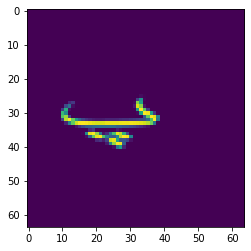

In [ ]:
# Split the dataset into 80% train and 20% test sets.
train_data,test_data,_,_ = train_test_split(data,data,test_size=0.2)
train_data = np.array(train_data)
test_data = np.array(test_data)

# select a random image and display it
sample = 1190
img = Image.fromarray(train_data[sample])
plt.imshow(img)

In [ ]:
# Normalizing train and test data
normalized_train_data = train_data.astype('float32')/255.0
normalized_test_data = test_data.astype('float32')/255.0

# Reshaping train and test sets, i.e. changing from (64, 64) to (64, 64, 1)
normalized_train_data = np.expand_dims(normalized_train_data,axis=-1)
normalized_test_data = np.expand_dims(normalized_test_data,axis=-1)
print('Normalization and reshaping is done.')
print('Input shape = {}'.format(normalized_train_data.shape[1:]))

Normalization and reshaping is done.
Input shape = (64, 64, 1)


### Defining the Encoder


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten
from tensorflow.keras.layers import Reshape, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard

image_width  = 64
image_height = 64
n_epochs     = 15
batch_size   = 128

input_img = Input(shape=(image_width, image_height, 1))  

# You can experiment with the encoder layers, i.e. add or change them
x = Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(input_img)
x = Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)

# We need this shape later in the decoder, so we save it into a variable.
encoded_shape = K.int_shape(x)

x = Flatten()(x)
encoded = Dense(128)(x)

# Builing the encoder
encoder = Model(input_img,encoded,name='encoder')

# at this point the representation is 128-dimensional
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
flatten_5 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               2097280   
Total params: 2,116,096
Trainable params: 2,116,096
Non-trainable params: 0
_________________________________________________________________


### Defining the Decoder

In [ ]:
# Input shape for decoder
encoded_input = Input(shape=(128,))
x = Dense(np.prod(encoded_shape[1:]))(encoded_input)
x = Reshape((encoded_shape[1], encoded_shape[2], encoded_shape[3]))(x)
x = Conv2DTranspose(64,(3, 3), activation='relu',strides=2, padding='same')(x)
x = Conv2DTranspose(32,(3, 3), activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(1,(3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(encoded_input,x,name='decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_11 (Dense)             (None, 16384)             2113536   
_________________________________________________________________
reshape_5 (Reshape)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 64, 64, 32)        18464     
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 64, 64, 1)         289       
Total params: 2,169,217
Trainable params: 2,169,217
Non-trainable params: 0
_________________________________________________

### Defining the Autoencoder

In [ ]:
autoencoder = Model(input_img, decoder(encoder(input_img)),name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 64, 64, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 128)               2116096   
_________________________________________________________________
decoder (Model)              (None, 64, 64, 1)         2169217   
Total params: 4,285,313
Trainable params: 4,285,313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile and train the model. Log and visualize using tensorboard
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

h = autoencoder.fit(normalized_train_data, normalized_train_data,
                epochs=n_epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(normalized_test_data, normalized_test_data),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 8000 samples, validate on 2000 samples
Epoch 1/15
8000/8000 [==============================] - 33s 4ms/sample - loss: 0.0834 - val_loss: 0.0717
Epoch 2/15
8000/8000 [==============================] - 31s 4ms/sample - loss: 0.0581 - val_loss: 0.0460
Epoch 3/15
8000/8000 [==============================] - 32s 4ms/sample - loss: 0.0377 - val_loss: 0.0324
Epoch 4/15
8000/8000 [==============================] - 32s 4ms/sample - loss: 0.0292 - val_loss: 0.0278
Epoch 5/15
8000/8000 [==============================] - 32s 4ms/sample - loss: 0.0260 - val_loss: 0.0257
Epoch 6/15
8000/8000 [==============================] - 31s 4ms/sample - loss: 0.0244 - val_loss: 0.0247
Epoch 7/15
8000/8000 [==============================] - 31s 4ms/sample - loss: 0.0236 - val_loss: 0.0242
Epoch 8/15
8000/8000 [==============================] - 32s 4ms/sample - loss: 0.0231 - val_loss: 0.0236
Epoch 9/15
8000/8000 [==============================] - 32s 4ms/sample - loss: 0.0226 - val_loss: 0.0233
Epoch 1

In [ ]:
#hide
# Plot the training history using altair

import altair as alt
import pandas as pd

train_source = pd.DataFrame({'x':np.arange(0,n_epochs), 'y':h.history['loss'], 'orig_label': 15 * ['train_loss']})
val_source = pd.DataFrame({'x':np.arange(0,n_epochs), 'y':h.history['val_loss'], 'val_label': 15 * ['val_loss']})
legends = ['train loss', 'val loss']

train_chart = alt.Chart(train_source).mark_line().encode(
    alt.X('x', title='Epochs'),
    alt.Y('y', title='Loss/Accuracy'),
    color=alt.Color('orig_label:O', legend=alt.Legend(title=None))
)
val_chart = alt.Chart(val_source).mark_line().encode(
    alt.X('x', title='Epochs'),
    alt.Y('y', title='Loss/Accuracy'),
    color=alt.Color('val_label:O', scale=alt.Scale(range=['red']), legend=alt.Legend(title=None))

    
)
# alt.layer(train_chart, val_chart).resolve_scale(color='independent')


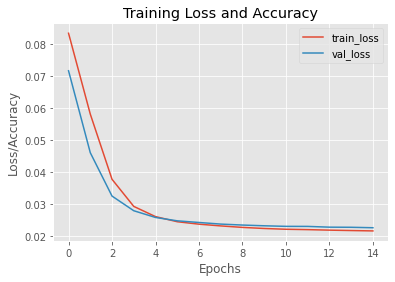

In [ ]:
# plot the train and validation losses
N = np.arange(0, n_epochs)
plt.figure()
plt.plot(N, h.history['loss'], label='train_loss')
plt.plot(N, h.history['val_loss'], label='val_loss')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='upper right')

TensorBoard also provides plenty of useful information including measurements and visualizations during and after training. The snippet below shows the training loss in TensorBoard:

![](images/autoen_tensorboard.png)


In [ ]:
# Make predictions on the test set
decoded_imgs = autoencoder.predict(normalized_test_data)

In [ ]:
def visualize(model, X_test, n_samples): 
    """ Visualizes the original images and the reconstructed ones for `n_samples` examples 
    on the test set `X_test`."""
      
    # Reconstructing the encoded images 
    reconstructed_images = model.predict(X_test) 
      
    plt.figure(figsize =(20, 4)) 
    for i in range(1, n_samples): 
          
        # Generating a random to get random results 
        rand_num = np.random.randint(0, 2000) 
      
        # To display the original image 
        ax = plt.subplot(2, 10, i) 
        plt.imshow(X_test[rand_num].reshape(image_width, image_width)) 
        plt.gray() 
        ax.get_xaxis().set_visible(False) 
        ax.get_yaxis().set_visible(False) 
  
        # To display the reconstructed image 
        ax = plt.subplot(2, 10, i + 10) 
        plt.imshow(reconstructed_images[rand_num].reshape(image_width, image_width)) 
        plt.gray() 
        ax.get_xaxis().set_visible(False) 
        ax.get_yaxis().set_visible(False) 
          
    # Displaying the plot 
    plt.show() 

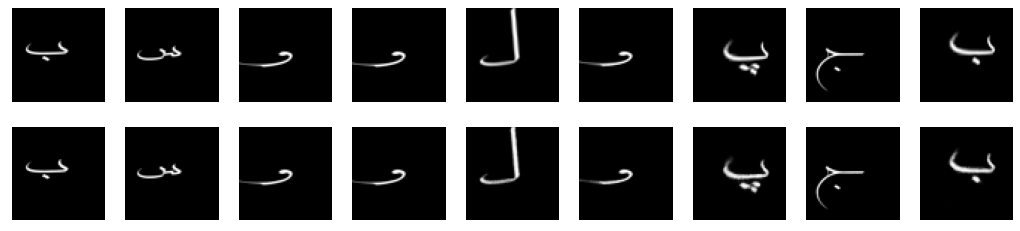

In [ ]:
# Plots `n_samples` images. Top row is the original images and the lower row is the reconstructed ones.
n_samples = 10
visualize(autoencoder,normalized_test_data, n_samples)

## Variational Autoencoders (VAE)

### Limitations of Autoencoders for Content Generation

After we train an autoencoder, we might think whether we can use the model to create new content. Particularly, we may ask *can we take a point randomly from that latent space and decode it to get a new content?*

The answer is "yes", but but quality and relevance of generated data depend on the regularity of the latent space. The latent space regularity depends on the *distribution of the initial data*, the *dimension of the latent space* and the *architecture of the encoder*. It is quite difficult to ensure, a priori, that the encoder will organize the latent space in a smart way compatible with the generative process I mentioned. No regularization means overfitting, which leads to meaningless content once decoded for some point. For more information, see [this nice blog](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73). 

How can we make sure the latent space is regularized enough? We can explicitly introduce regularization during the training process. Therefore, we introduce **Variational Autoencoders**.

### Variational Autoencoder (VAE)

It's an autoencoder whose training is regularized to avoid overfitting and ensure that the latent space has good properties that enable generative process. The idea is instead of mapping the input into a fixed vector, we want to map it into a distribution. In other words, the encoder outputs two vectors of size $n$, a vector of means $\mathbf{\mu}$, and another vector of standard variations $\mathbf{\sigma}$.

![](images/autoen_vae1.png)
*Difference between autoencoder (deterministic) and variational autoencoder (probabilistic). [[Image Source](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)]*

The encoded distributions are often normal so that the encoder can be trained to return the mean and the covariance matrix that describe these Gaussians. We force the encoder to return the distributions that are close to a standard normal distribution.

![](images/autoen_vae-gaussian.png)
*Variational autoencoder model with the multivariate Gaussian assumption.[[]Image Source](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)*

### VAE Loss Function

The loss function that we need to minimize for VAE consists of two components: (a) reconstruction term, which is similar to the loss function of regular autoencoders; and (b) regularization term, which regularizes the latent space by making the distributions returned by the encoder close to a standard normal distribution. We use the Kullback-Leibler divergence to quantify the difference between the returned distribution and a standard Gaussian. KL divergence $D_{KL}(X\|Y)$ measures how much information is lost if the distribution $Y$ is used to represent $X$. I am not willing to go deeply into the mathmatical details of VAE, however, all the math details have been nicely described [here](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html) and [here](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) among other places.

$$L_{VAE}=\|\mathbf{x}-\mathbf{x'}\|^2 - D_{KL}[N(\mu_{\mathbf{x}},\sigma_{\mathbf{x}})\|N(0,1)]$$

$$D_{KL}[N(\mu_{\mathbf{x}},\sigma_{\mathbf{x}})\|N(0,1)]=\frac{1}{2}\sum_{k} (\sigma_{\mathbf{x}} + \mu_{\mathbf{x}}^2 -1 - \log(\sigma_{\mathbf{x}}))$$

where $k$ is the dimension of the Gaussian. In practice, however, it’s better to model $\sigma_{\mathbf{x}}$ rather than $\log(\sigma_{\mathbf{x}})$ as it is more numerically stable to take exponent compared to computing log. Hence, our final KL divergence term is:

$$D_{KL}[N(\mu_{\mathbf{x}},\sigma_{\mathbf{x}})\|N(0,1)]=\frac{1}{2}\sum_{k} (\exp(\sigma_{\mathbf{x}}) + \mu_{\mathbf{x}}^2 -1 - \sigma_{\mathbf{x}})$$

What is important is that the VAE loss function involves generating samples from $\mathbf{z}\sim N(\mathbf{\mu},\mathbf{\sigma})$. Since Sampling is a stochastic process, we cannot backpropagate the gradient while training the model. To make it trainable, a simple trick, called reparametrization trick, is used to make the gradient descent possible despite the random sampling that occurs halfway of the architecture. In this trick, random variable $\mathbf{z}$ is expressed as a deterministic variable $\mathbf{z}=\mathcal{T}_{\phi}(\mathbf{x},\mathbf{\epsilon})$, where $\mathbf{\epsilon}$ is an auxiliary independent random variable, and the transformation function $\mathcal{T}_{\phi}$ parameterized by ϕ converts $\mathbf{\epsilon}$ to $\mathbf{z}$.

If $\mathbf{z}$ is a random variable following a Gaussian distribution with mean $\mathbf{\mu}$ and with covariance $\mathbf{\sigma}$ then it can be expressed as:

$$\mathbf{z}=\mathbf{\mu}+\mathbf{\sigma}\odot \mathbf{\epsilon}$$

where $\odot$ is the element-wise multiplication.

![](images/autoen_vae_backprop.png)
*Illustration of the reparametrisation trick. [[Image Source](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)]*

### VAE Implementation

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten
from tensorflow.keras.layers import Reshape, BatchNormalization, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import TensorBoard

# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sample_z(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    mu, sigma = args
    batch     = K.shape(mu)[0]
    dim       = K.int_shape(mu)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    eps       = K.random_normal(shape=(batch, dim))
    return mu + K.exp(sigma / 2) * eps



image_width  = 64
image_height = 64
latent_dim   = 2
no_epochs    = 30
batch_size   = 128
num_channels = 1

# Defining the encoder
inputs = Input(shape=(image_width, image_height, 1), name='encoder_input')  

x = Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(inputs)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
x = BatchNormalization()(x)
conv_shape = K.int_shape(x)
x = Flatten()(x)
x = Dense(16)(x)
x = BatchNormalization()(x)
mu = Dense(latent_dim, name='latent_mu')(x)
sigma = Dense(latent_dim, name='latent_sigma')(x)

# use reparameterization trick to push the sampling out as input
z  = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])


encoder = Model(inputs, [mu, sigma, z], name='encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 32, 32, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 32, 32, 32)   128         conv2d_14[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 16, 16, 64)   18496       batch_normalization_6[0][0]      
____________________________________________________________________________________________

In [ ]:
# Defining decoder
d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(8, (3, 3), strides=2, padding='same',  activation='relu')(cx)
cx    = BatchNormalization()(cx)
o     = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same', name='decoder_output')(cx)

# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_15 (Dense)             (None, 16384)             49152     
_________________________________________________________________
batch_normalization_9 (Batch (None, 16384)             65536     
_________________________________________________________________
reshape_7 (Reshape)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose_20 (Conv2DT (None, 32, 32, 16)        9232      
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 64, 64, 8)         1160

In [ ]:
# Build VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 64, 64, 1)]       0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 281492    
_________________________________________________________________
decoder (Model)              (None, 64, 64, 1)         125249    
Total params: 406,741
Trainable params: 373,701
Non-trainable params: 33,040
_________________________________________________________________


In [ ]:
def vae_loss(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * image_width * image_height
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

In [ ]:
vae.compile(optimizer='adam', loss=vae_loss, experimental_run_tf_function=False)
vae.fit(normalized_train_data, normalized_train_data,
        epochs=no_epochs,
        batch_size=batch_size,
        validation_data=(normalized_test_data, normalized_test_data),
        callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 8000 samples, validate on 2000 samples
Epoch 1/30
8000/8000 [==============================] - 25s 3ms/sample - loss: 3249.4657 - val_loss: 2144.2753
Epoch 2/30
8000/8000 [==============================] - 26s 3ms/sample - loss: 1365.3898 - val_loss: 865.2598
Epoch 3/30
8000/8000 [==============================] - 24s 3ms/sample - loss: 549.6889 - val_loss: 486.4303
Epoch 4/30
8000/8000 [==============================] - 24s 3ms/sample - loss: 360.0920 - val_loss: 422.2506
Epoch 5/30
8000/8000 [==============================] - 24s 3ms/sample - loss: 304.1477 - val_loss: 396.6112
Epoch 6/30
8000/8000 [==============================] - 24s 3ms/sample - loss: 280.2429 - val_loss: 363.0641
Epoch 7/30
8000/8000 [==============================] - 23s 3ms/sample - loss: 265.6487 - val_loss: 325.5147
Epoch 8/30
8000/8000 [==============================] - 23s 3ms/sample - loss: 256.7028 - val_loss: 290.9990
Epoch 9/30
8000/8000 [==============================] - 23s 3ms/sample - loss

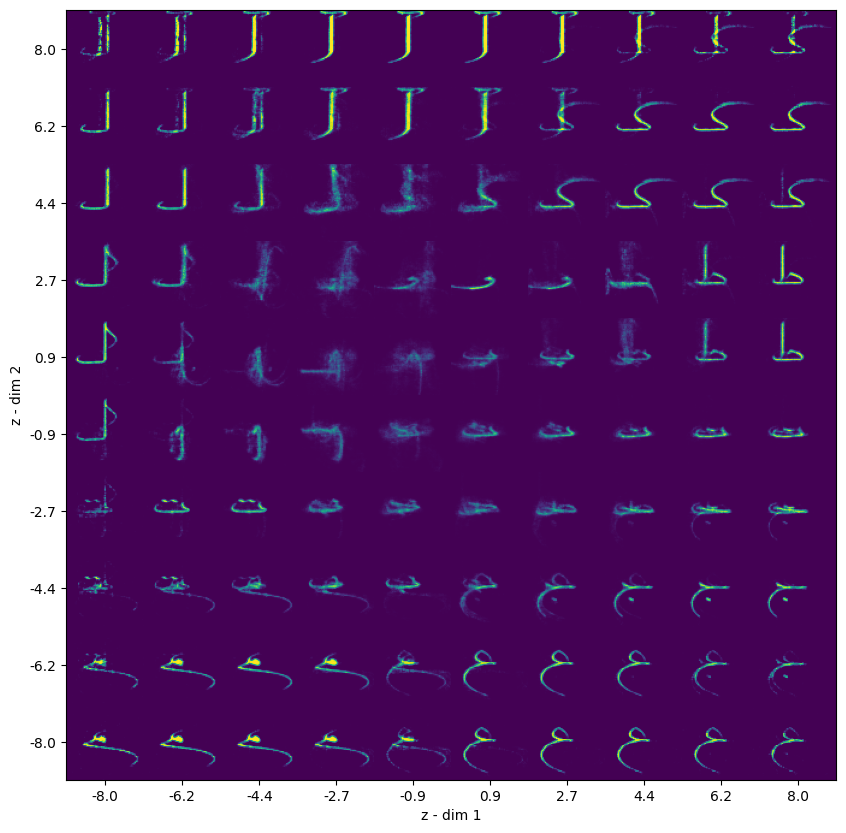

In [ ]:
# Credit for code: https://www.machinecurve.com/index.php/2019/12/30/how-to-create-a-variational-autoencoder-with-keras/

def viz_decoded(encoder, decoder, data):
    """ Visualizes the samples from latent space."""
    num_samples = 10
    figure = np.zeros((image_width * num_samples, image_height * num_samples, num_channels))
    grid_x = np.linspace(-8, 8, num_samples)
    grid_y = np.linspace(-8, 8, num_samples)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
#             z_sample = np.array([np.random.normal(0, 1, latent_dim)])
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(image_width, image_height, num_channels)
            figure[i * image_width: (i + 1) * image_width,
                  j * image_height: (j + 1) * image_height] = digit
    plt.figure(figsize=(10, 10))
    start_range = image_width // 2
    end_range = num_samples * image_width + start_range + 1
    pixel_range = np.arange(start_range, end_range, image_width)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
    # So reshape if necessary
    fig_shape = np.shape(figure)
    if fig_shape[2] == 1:
        figure = figure.reshape((fig_shape[0], fig_shape[1]))
    # Show image
    plt.imshow(figure)
    plt.show()

# Plot results
data = (normalized_test_data, normalized_test_data)
# data = (normalized_train_data, normalized_train_data)

viz_decoded(encoder, decoder, data)

If you notice the plot above, in the upper right corner and around (-8,-2.7), we see the issue with completeness, which yield outputs that do not make sense. Also, some issues with continuity are visible wherever the samples are blurred.
**continuity** i.e. two close points in the latent space should not give two completely different contents once decoded, and **completeness** i.e. for a chosen distribution, a point sampled from the latent space should give “meaningful” content once decoded, are two primary properties of a regularized latent space.

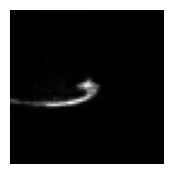

In [ ]:
# Randomly sample one or more charachters and plot them
random_chars = [np.random.normal(0, 1, latent_dim) for _ in range(1)]
imgs = []
for char in random_chars:
    char = char.reshape(-1,2)
    imgs.append(decoder.predict(char))

imgs = [np.reshape(img,(image_width, image_height)) for img in imgs]
for img in imgs:
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow(img, cmap='gray')

### Creating Morph Images

For morphing images, the approach is somewhat different than generating new images of characters. There are four main steps:

1. Choose two images that you want to morph between
2. Put both images into the VAE's encoder and get a latent vector out for each
3. Choose several intermediate vectors between the two latent vectors
4. Take the intermediate vectors and pass them into the VAE's decoder to generate images

In [ ]:
import moviepy.editor as mpy

def load_image(file_path):
    img = Image.open(file_path)
    img_array = np.array(img)
    return img_array

def generate_morph_images(image_1, image_2, encoder, decoder, n_steps):
    image_1 = image_1.astype('float32')/255.0
    image_2 = image_2.astype('float32')/255.0
    np.expand_dims(image_1,axis=-1)
    np.expand_dims(image_2,axis=-1)
    vec1 = encoder.predict(image_1.reshape(-1,image_width,image_height,1))[2]
    vec2 = encoder.predict(image_2.reshape(-1,image_width,image_height,1))[2]
    morph_vecs = [
        np.add(
            np.multiply(vec1, (n_steps - 1 - i) / (n_steps - 1)),
            np.multiply(vec2, i / (n_steps - 1)),
        )
        for i in range(n_steps)
    ]

    return[decoder.predict(vec) for vec in morph_vecs]



def animate_morph_images(image_1, image_2, encoder, decoder, n_steps, loop=True):
    morph_images = [
        np.multiply(f[0], 255) for f in generate_morph_images(image_1, image_2, encoder, decoder, n_steps)
    ]
    if loop:
        morph_images = (
            int(n_steps / 5) * [morph_images[0]]
            + morph_images
            + int(n_steps / 5) * [morph_images[-1]]
            + morph_images[::-1]
        )

    return mpy.ImageSequenceClip(morph_images, fps=50, with_mask=False)

def animate_morph_images_from_morph(morph_images, n_steps, loop=True):
    if loop:
        morph_images = (
            int(n_steps / 5) * [morph_images[0]]
            + morph_images
            + int(n_steps / 5) * [morph_images[-1]]
            + morph_images[::-1]
        )

    return mpy.ImageSequenceClip(morph_images, fps=25, with_mask=False)

In [ ]:
img1_path = os.path.join('data','converted', 'output', 'converted_original_7.png_daf7cc5a-4c6f-467b-a4e5-faffb245aa68.png')
img2_path = os.path.join('data','converted', 'output', 'converted_original_10.png_17dc166c-00b3-4812-a149-d6c740de1d8c.png')


img1 = load_image(img1_path)
img2 = load_image(img2_path)

n_steps = 90
clip = animate_morph_images(img1, img2,encoder,decoder,n_steps)

# Uncomment the line below if you want to see the video clip
# clip.ipython_display(width=400)

In [ ]:
# Create a .gif image
clip.write_gif('7to10.gif', fps=10)

MoviePy - Building file 7to10.gif with imageio.


The image below is morphing between two characters.

![](images/7to10.gif)

## Extra Resources

[1] [From autoencoder to Beta-VAE](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)

[2] [Understanding Variational Autoencoders](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

[3] [Autoencoder, What is it?](https://towardsdatascience.com/auto-encoder-what-is-it-and-what-is-it-used-for-part-1-3e5c6f017726)
